In [171]:
# %pip install networkx

In [172]:
# Base imports
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# Classifier imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Graph of Thrones

Let's take a look at a dataset containing the characters that appear in G.R.R Martin's epic fantasy series *A Song of Ice and Fire*. Can we predict who lives and dies in the first book based on a character's Allegiance, Gender, Nobility and the chapter in which they are introduced? 

In [173]:
# Get a list of characters from the first book, print the first 5
characters =[]
with open('data/asoiaf-book1-nodes.csv') as f: [characters.append(line.split(',')[1].strip()) for line in f]
characters.pop(0) # pop out the label
characters[:5]

['Addam Marbrand',
 'Aegon I Targaryen',
 'Aemon Targaryen (Maester Aemon)',
 'Aerys II Targaryen',
 'Aggo']

In [174]:
# Read in data regarding deaths
death_df = pd.read_csv('data/character-deaths.csv')
death_df.head()

,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD
0,Addam Marbrand,Lannister,NaN,NaN,NaN,56.0,1,1,1,1,1,1,0
1,Aegon Frey (Jinglebell),None,299.0,3.0,51.0,49.0,1,1,0,0,1,0,0
2,Aegon Targaryen,House Targaryen,NaN,NaN,NaN,5.0,1,1,0,0,0,0,1
3,Adrack Humble,House Greyjoy,300.0,5.0,20.0,20.0,1,1,0,0,0,0,1
4,Aemon Costayne,Lannister,NaN,NaN,NaN,NaN,1,1,0,0,1,0,0


In [175]:
# Create target variable
death_df['Dead'] = death_df['Death Year'].apply(lambda x: 1 if x==x else 0)

In [176]:
# Compare count of Characters in each set
print(f"""Total Characters: {len(death_df)}, First Book Characters: {len(death_df.query(f'Name in {characters}'))}""")

Total Characters: 917, First Book Characters: 156


In [177]:
# Grab death data from Characters in the first book
first_deaths = death_df.query(f'Name in {characters}').reset_index(drop=True)
first_deaths.head()

,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD,Dead
0,Addam Marbrand,Lannister,NaN,NaN,NaN,56.0,1,1,1,1,1,1,0,0
1,Aggo,House Targaryen,NaN,NaN,NaN,54.0,1,0,1,1,1,0,1,0
2,Albett,Night's Watch,NaN,NaN,NaN,26.0,1,0,1,0,0,0,0,0
3,Alliser Thorne,Night's Watch,NaN,NaN,NaN,19.0,1,0,1,1,1,0,1,0
4,Alyn,House Stark,298.0,3.0,34.0,12.0,1,0,1,0,0,0,0,1


In [178]:
# Grab relevant features and one hot encode categorical data (Allegiances)
features = ['Name','Book Intro Chapter','Gender','Nobility','Dead']
df=pd.concat([first_deaths[features],pd.get_dummies(first_deaths['Allegiances'], prefix='allegiance',drop_first=True)],axis=1)
df.head()


,Name,Book Intro Chapter,Gender,Nobility,Dead,allegiance_Baratheon,allegiance_House Arryn,allegiance_House Baratheon,allegiance_House Greyjoy,allegiance_House Lannister,...,allegiance_House Tully,allegiance_House Tyrell,allegiance_Lannister,allegiance_Night's Watch,allegiance_None,allegiance_Stark,allegiance_Targaryen,allegiance_Tully,allegiance_Tyrell,allegiance_Wildling
0,Addam Marbrand,56.0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,Aggo,54.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Albett,26.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,Alliser Thorne,19.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Alyn,12.0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Predicting Death

### Tabular Data
>*Valar Morghulis* (All Men must die) -- A Clash of Kings

In [179]:
# Try a collection of classifiers
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Random Forest", "Neural Net","Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=3,random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    LogisticRegression(solver='liblinear', random_state=42)]

In [180]:
# Prepare data
X, y = df.drop(['Name','Dead'],axis=1), df['Dead']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.2, random_state=42)

In [182]:
# Untuned classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(f'Base F1 Score for {name}: {f1_score(y_test, clf.predict(X_test))}')

Base F1 Score for Nearest Neighbors: 0.48484848484848486
Base F1 Score for Linear SVM: 0.4666666666666667
Base F1 Score for RBF SVM: 0.38461538461538464
Base F1 Score for Random Forest: 0.3333333333333333
Base F1 Score for Neural Net: 0.41379310344827586
Base F1 Score for Logistic Regression: 0.3703703703703703


We now have some baseline scores for models built solely on tabular data.

### Graph Data
>Every Man must die, but first He must live. -- Storm of Swords<
Let's see if we can capture more information 

In [223]:
# Import graph database
book1_df = pd.read_csv('data/asoiaf-book1-edges.csv')
G1 = nx.Graph()
for row in book1_df.iterrows():
    G1.add_edge(row[1]['Source'].replace('-',' '), row[1]['Target'].replace('-',' '), weight=row[1]['weight'])

In [224]:
# Inspect relationship/edge
G1.get_edge_data('Tyrion Lannister','Jon Snow')

{'weight': 56}

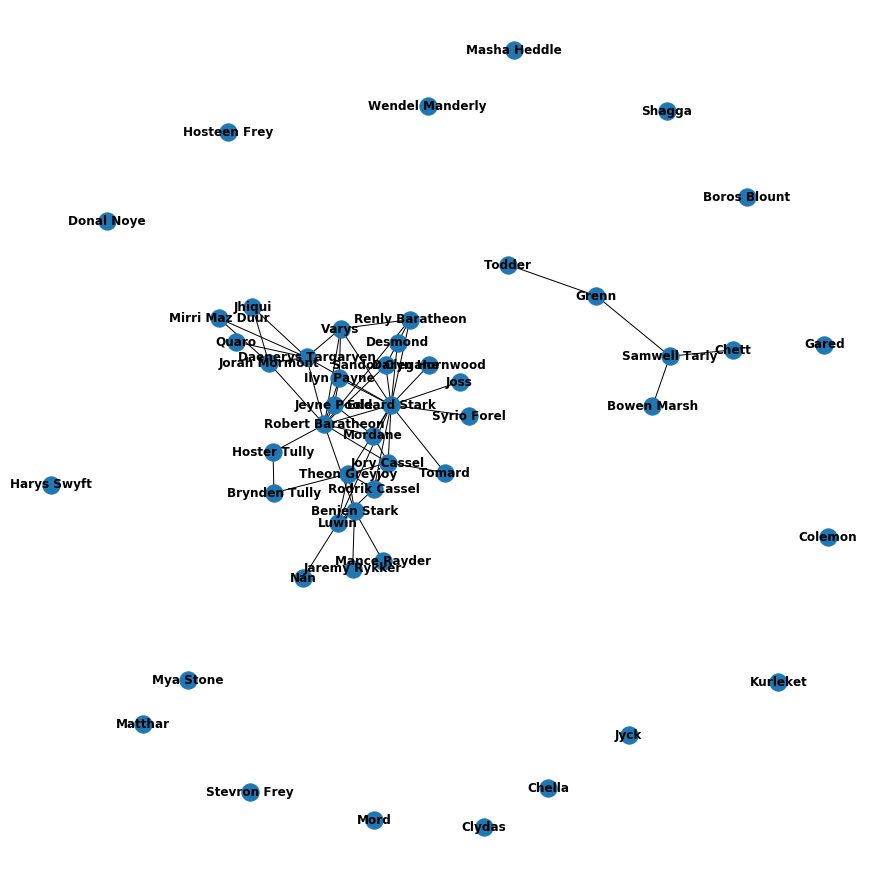

In [222]:
# Visualize a sample of the graph
ax = plt.figure(figsize=(12,12))
nx.draw(G1.subgraph(df.sample(n=50, random_state=42).Name), with_labels=True, font_weight='bold')
plt.draw()

### Graph Algorithms

Using Graph Theory let us create some metrics from our network to augment the tabular data used in the models earlier.

#### Degree (number of connections normalized by number of possible connections)


In [139]:
# Calculate degree and assign it to each node
for name, degree in nx.degree_centrality(G1).items():
    G1.nodes[name]['degree']=degree

In [140]:
G1.nodes['Tyrion Lannister']

{'degree': 0.24731182795698928}

#### Label propagation (community detection algorithm akin to KNN)

In [141]:
# Assign community label to each node in the community and then print out the communities
communities=[]
for label, community in enumerate(nx.algorithms.community.label_propagation.label_propagation_communities(G1)):
    communities.append(community)
    print(community)
    for name in community:
        G1.nodes[name]['community'] = label

{'Waymar Royce', 'Will (prologue)', 'Gared'}
{'Danwell Frey', 'Jared Frey', 'Hosteen Frey'}
{'Doreah', 'Aggo', 'Ogo', 'Cohollo', 'Jommo', 'Drogo', 'Jorah Mormont', 'Qotho', 'Viserys Targaryen', 'Daenerys Targaryen', 'Haggo', 'Rakharo', 'Rhaego', 'Jhogo', 'Mirri Maz Duur', 'Irri', 'Fogo', 'Eroeh', 'Quaro', 'Jhiqui', 'Illyrio Mopatis'}
{'Morrec', 'Jyck'}
{'Paxter Redwyne', 'Mace Tyrell'}
{'Todder', 'Chett', 'Dywen', 'Clydas', 'Randyll Tarly', 'Bowen Marsh', 'Rast', 'Jeor Mormont', 'Matthar', 'Albett', 'Hobb', 'Dareon', 'Alliser Thorne', 'Aemon Targaryen (Maester Aemon)', 'Jaremy Rykker', 'Samwell Tarly', 'Othor', 'Grenn', 'Jafer Flowers', 'Halder', 'Donal Noye', 'Jon Snow', 'Pypar'}
{'Coratt', 'Conn'}
{'Dolf', 'Shagga', 'Ulf son of Umar', 'Timett'}
{'Lancel Lannister', 'Chiggen', 'Joffrey Baratheon', 'Porther', 'Tregar', 'Wylla', 'Mya Stone', 'Brynden Tully', 'Tyrion Lannister', 'Arthur Dayne', 'Roose Bolton', 'Eddard Stark', 'Petyr Baelish', 'Gregor Clegane', 'Galbart Glover', 'Jeyne Po

#### EDA
What information does the edge weights capture?

In [142]:
wts=[]
relationships=[]
# Loop through each node and its adjacent nodes and capture its weight 
for n, nbrs in G1.adj.items():
    for nbr, eattr in nbrs.items():
        wt = eattr['weight']
        wts.append(wt)
        relationships.append((wt,n,nbr))

In [143]:
# Examine weighted relationship, skip every other one (undirected relationship)
sorted(relationships,key=(lambda x: x[0]),reverse=False)[:10:2]

[(0.003436426116838488, 'Eddard Stark', 'Robert Baratheon'),
 (0.008928571428571428, 'Bran Stark', 'Robb Stark'),
 (0.009615384615384616, 'Arya Stark', 'Sansa Stark'),
 (0.009900990099009901, 'Daenerys Targaryen', 'Drogo'),
 (0.011494252873563218, 'Joffrey Baratheon', 'Sansa Stark')]

(array([110., 118., 166., 112., 158., 158.,   0., 216.,   0., 330.]),
 array([0.00343643, 0.03642612, 0.06941581, 0.1024055 , 0.13539519,
        0.16838488, 0.20137457, 0.23436426, 0.26735395, 0.30034364,
        0.33333333]),
 <a list of 10 Patch objects>)

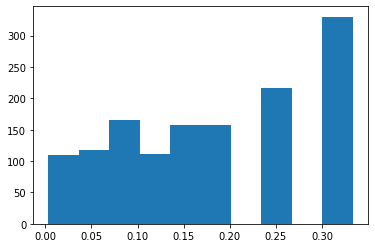

In [144]:
# Plot distribution of weights
plt.hist(wts)

#### Centrality

In [156]:
# Assign betweenness metric
for name, betweenness in nx.betweenness_centrality(G1, seed=42).items():
    G1.nodes[name]['betweenness']=betweenness

In [157]:
G1.nodes['Tyrion Lannister']

{'degree': 0.24731182795698928,
 'community': 8,
 'betweenness': 0.1902124972697492,
 'rank': 0.02615193327458755}

In [158]:
# Assign pagerank
for name, rank in nx.pagerank(G1).items():
    G1.nodes[name]['rank']=rank

In [159]:
G1.nodes['Tyrion Lannister']

{'degree': 0.24731182795698928,
 'community': 8,
 'betweenness': 0.1902124972697492,
 'rank': 0.02615193327458755}

## Augmented Data

In [161]:
# Helper function to augment table data
def graph_of_thrones(name):
    if G1.nodes[name]:
        return [G1.nodes[name]['betweenness'], G1.nodes[name]['community'], G1.nodes[name]['rank'], G1.nodes[name]['degree']]
    return [None, None, None, None]

In [162]:
# Add metrics to original DataFrame
graph_df = pd.concat([df,pd.DataFrame(df.apply(lambda x: graph_of_thrones(x.Name),axis=1).values.tolist(),columns=['Betweenness','Community','Rank','Degree'])],axis=1)
graph_df.columns

Index(['Name', 'Book Intro Chapter', 'Gender', 'Nobility', 'Dead',
       'allegiance_Arryn', 'allegiance_Baratheon', 'allegiance_House Arryn',
       'allegiance_House Baratheon', 'allegiance_House Greyjoy',
       'allegiance_House Lannister', 'allegiance_House Stark',
       'allegiance_House Targaryen', 'allegiance_House Tully',
       'allegiance_House Tyrell', 'allegiance_Lannister',
       'allegiance_Night's Watch', 'allegiance_None', 'allegiance_Stark',
       'allegiance_Targaryen', 'allegiance_Tully', 'allegiance_Tyrell',
       'allegiance_Wildling', 'allegiance_nan', 'Betweenness', 'Community',
       'Rank', 'Degree'],
      dtype='object')

In [163]:
augmented_df=pd.concat([graph_df,pd.get_dummies(graph_df['Community'], prefix='community',dummy_na=True)],axis=1)

In [164]:
augmented_df.columns

Index(['Name', 'Book Intro Chapter', 'Gender', 'Nobility', 'Dead',
       'allegiance_Arryn', 'allegiance_Baratheon', 'allegiance_House Arryn',
       'allegiance_House Baratheon', 'allegiance_House Greyjoy',
       'allegiance_House Lannister', 'allegiance_House Stark',
       'allegiance_House Targaryen', 'allegiance_House Tully',
       'allegiance_House Tyrell', 'allegiance_Lannister',
       'allegiance_Night's Watch', 'allegiance_None', 'allegiance_Stark',
       'allegiance_Targaryen', 'allegiance_Tully', 'allegiance_Tyrell',
       'allegiance_Wildling', 'allegiance_nan', 'Betweenness', 'Community',
       'Rank', 'Degree', 'community_0.0', 'community_1.0', 'community_2.0',
       'community_3.0', 'community_4.0', 'community_5.0', 'community_6.0',
       'community_7.0', 'community_8.0', 'community_nan'],
      dtype='object')

In [165]:
# Prepare data
X, y = augmented_df.drop(['Name','Dead','Community','community_nan','allegiance_nan'],axis=1), augmented_df['Dead']
X = StandardScaler().fit_transform(X)
GX_train, GX_test, Gy_train, Gy_test = \
        train_test_split(X, y, test_size=.2, random_state=42)

In [166]:
# Untuned Classifiers no weight
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(f'Base F1 Score for {name}: {f1_score(y_test, clf.predict(X_test))}')
    clf.fit(GX_train, Gy_train)
    print(f'Graph Augmented F1 Score for {name}: {f1_score(Gy_test, clf.predict(GX_test))} \n')

Base F1 Score for Nearest Neighbors: 0.5625
Graph Augmented F1 Score for Nearest Neighbors: 0.4666666666666667 

Base F1 Score for Linear SVM: 0.4666666666666667
Graph Augmented F1 Score for Linear SVM: 0.5 

Base F1 Score for RBF SVM: 0.38461538461538464
Graph Augmented F1 Score for RBF SVM: 0.4827586206896552 

Base F1 Score for Random Forest: 0.24000000000000005
Graph Augmented F1 Score for Random Forest: 0.32 

Base F1 Score for Neural Net: 0.4666666666666667
Graph Augmented F1 Score for Neural Net: 0.45161290322580644 

Base F1 Score for Logistic Regression: 0.3703703703703703
Graph Augmented F1 Score for Logistic Regression: 0.5185185185185185 



In [136]:
# Untuned Classifiers (weight = weight)
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(f'Base F1 Score for {name}: {f1_score(y_test, clf.predict(X_test))}')
    clf.fit(GX_train, Gy_train)
    print(f'Graph Augmented F1 Score for {name}: {f1_score(Gy_test, clf.predict(GX_test))} \n')

Base F1 Score for Nearest Neighbors: 0.5625
Graph Augmented F1 Score for Nearest Neighbors: 0.41379310344827586 

Base F1 Score for Linear SVM: 0.4666666666666667
Graph Augmented F1 Score for Linear SVM: 0.5 

Base F1 Score for RBF SVM: 0.38461538461538464
Graph Augmented F1 Score for RBF SVM: 0.3076923076923077 

Base F1 Score for Random Forest: 0.24000000000000005
Graph Augmented F1 Score for Random Forest: 0.35714285714285715 

Base F1 Score for Neural Net: 0.4666666666666667
Graph Augmented F1 Score for Neural Net: 0.39999999999999997 

Base F1 Score for Logistic Regression: 0.3703703703703703
Graph Augmented F1 Score for Logistic Regression: 0.5 



In [155]:
# Untuned Classifiers weight = inverse
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(f'Base F1 Score for {name}: {f1_score(y_test, clf.predict(X_test))}')
    clf.fit(GX_train, Gy_train)
    print(f'Graph Augmented F1 Score for {name}: {f1_score(Gy_test, clf.predict(GX_test))} \n')

Base F1 Score for Nearest Neighbors: 0.5625
Graph Augmented F1 Score for Nearest Neighbors: 0.4666666666666667 

Base F1 Score for Linear SVM: 0.4666666666666667
Graph Augmented F1 Score for Linear SVM: 0.5 

Base F1 Score for RBF SVM: 0.38461538461538464
Graph Augmented F1 Score for RBF SVM: 0.4827586206896552 

Base F1 Score for Random Forest: 0.24000000000000005
Graph Augmented F1 Score for Random Forest: 0.39999999999999997 

Base F1 Score for Neural Net: 0.4666666666666667
Graph Augmented F1 Score for Neural Net: 0.39999999999999997 

Base F1 Score for Logistic Regression: 0.3703703703703703
Graph Augmented F1 Score for Logistic Regression: 0.5185185185185185 

